In [1]:
!pip install pydot
!pip install scikit-image Pillow
!pip install pytorch_fid
!pip uninstall -y tensorflow
!pip install tensorflow==2.15.0
import tensorflow as tf
print(tf.__version__)

Found existing installation: tensorflow 2.17.1
Uninstalling tensorflow-2.17.1:
  Successfully uninstalled tensorflow-2.17.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 59.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 61.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 56.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 8.0 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling

In [2]:
from tensorflow import keras
from keras.initializers import RandomNormal
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import numpy as np

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Use GPU if possible; Create a distributed training strategy to accelerate training
if tf.config.list_physical_devices('GPU'):
    strategy = tf.distribute.MirroredStrategy()
    print("Running on GPU.")
else:
    strategy = tf.distribute.get_strategy()
    print("Running on CPU.")

# Allow TF to dynamically determine the optimal number of parallel threads
AUTOTUNE = tf.data.experimental.AUTOTUNE

print(tf.__version__)

Running on GPU.
2.15.0


In [5]:
import glob
monet_tfrec = tf.io.gfile.glob('/content/drive/MyDrive/gan-getting-started/monet_tfrec/*.tfrec')
print('Number of .tfrec files containing monet painting:', len(monet_tfrec))

photo_tfrec = tf.io.gfile.glob('/content/drive/MyDrive/gan-getting-started/photo_tfrec/*.tfrec')
print('Number of .tfrec files containing landscape photo:', len(photo_tfrec))

monet_jpg = tf.io.gfile.glob('/content/drive/MyDrive/gan-getting-started/monet_jpg/*.jpg')
print('Number of monet paintings: ', len(monet_jpg))

photo_jpg = tf.io.gfile.glob('/content/drive/MyDrive/gan-getting-started/photo_jpg/*.jpg')
print('Number of landscape photos: ', len(photo_jpg))

Number of .tfrec files containing monet painting: 5
Number of .tfrec files containing landscape photo: 20
Number of monet paintings:  300
Number of landscape photos:  7038


In [6]:
# decodes jpg into a format suitable for TF processing
def decode_jpg_image(img):
    img = tf.image.decode_jpeg(img, channels=3)
    # https://www.beoptimized.be/pdf/TensorFlow2Cheatsheet.pdf
    img = tf.cast(img, tf.float32)
    # normalize img from (0, 255) to ()
    img = (img / 127.5) - 1
    img = tf.reshape(img, [256, 256, 3])
    return img

# Parse a single record from a .tfrec file and decode the image.
def parse_tfrec(serialized_image):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    serialized_image = tf.io.parse_single_example(serialized_image, tfrecord_format)
    img = decode_jpg_image(serialized_image['image'])
    return img

def load_dataset(filenames, labeled=True):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(parse_tfrec, num_parallel_calls=AUTOTUNE)
    return dataset

monet_ds = load_dataset(monet_tfrec).batch(1)
photo_ds = load_dataset(photo_tfrec).batch(1)

In [7]:
# the functions downsample() and upsample() are cited from https://keras.io/examples/generative/cyclegan/

# Creates a downsampling block that reduces spatial dimensions. Applying group normalization if needed.
def downsample(filters, size, add_gn = True):
    model_layers = [
        layers.Conv2D(
            filters,
            size,
            strides=2,
            padding='same',
            kernel_initializer=tf.random_normal_initializer(stddev = 0.02),
            use_bias=False
        ),
        layers.LeakyReLU()
    ]

    if add_gn:
        model_layers.insert(1, tf.keras.layers.GroupNormalization(gamma_initializer=RandomNormal(stddev=0.02), groups = -1))

    return keras.Sequential(model_layers)

# Creates a upsampling block that increases spatial dimensions. Applying dropout if needed.
def upsample(filters, size, with_dropout=False):
    model_layers = [
        layers.Conv2DTranspose(
            filters,
            size,
            strides=2,
            padding='same',
            kernel_initializer=tf.random_normal_initializer(stddev = 0.02),
            use_bias=False),
        tf.keras.layers.GroupNormalization(gamma_initializer=RandomNormal(stddev=0.02), groups=-1),
        layers.ReLU()
    ]

    if with_dropout:
        model_layers.insert(1, layers.Dropout(0.5))

    return keras.Sequential(model_layers)

In [8]:
def Generator():
    inputs = layers.Input(shape=[256,256,3])

    down_stack = [
        downsample(64, 4, add_gn=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
    ]

    up_stack = [
        upsample(512, 4, with_dropout=True),
        upsample(512, 4, with_dropout=True),
        upsample(512, 4, with_dropout=True),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4),
    ]

    initializer = tf.random_normal_initializer(stddev = 0.02)

    x = inputs

    # Downsampling
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    last = layers.Conv2DTranspose(3, 4, strides=2, padding='same', kernel_initializer=initializer, activation='tanh')

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

In [9]:
def Discriminator():
    initializer = tf.random_normal_initializer(stddev = 0.02)

    input = layers.Input(shape=[256, 256, 3], name='input_image')

    x = input

    zero_pad_layer = layers.ZeroPadding2D()(downsample(256, 4)(downsample(128, 4)(downsample(64, 4, False)(x))))
    conv = layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(zero_pad_layer)

    norm = tf.keras.layers.GroupNormalization(gamma_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.02), groups=-1)(conv)

    last = layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(layers.ZeroPadding2D()(layers.LeakyReLU()(norm)))

    return tf.keras.Model(inputs=input, outputs=last)

In [10]:
# Referenced https://keras.io/examples/generative/cyclegan/ to create the class CycleGan
class CycleGan(keras.Model):
    def __init__(self, painting_generator, photo_generator, painting_discriminator, photo_discriminator):
        super(CycleGan, self).__init__()
        self.gen_painting = painting_generator
        self.gen_photo = photo_generator
        self.disc_painting = painting_discriminator
        self.disc_photo = photo_discriminator
        self.lambda_cycle = 10

    def compile(self, gen_painting_optimizer, gen_photo_optimizer, disc_painting_optimizer, disc_photo_optimizer,
                gen_loss_fn, disc_loss_fn, cycle_loss_fn, identity_loss_fn):
        super(CycleGan, self).compile()
        self.gen_painting_optimizer = gen_painting_optimizer
        self.gen_photo_optimizer = gen_photo_optimizer
        self.disc_painting_optimizer = disc_painting_optimizer
        self.disc_photo_optimizer = disc_photo_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn

    def train_step(self, batch_data):
        real_painting, real_photo = batch_data

        with tf.GradientTape(persistent=True) as tape:
            # real photo -> fake painting
            fake_painting = self.gen_painting(real_photo, training=True)
            # real painting -> fake photo
            fake_photo = self.gen_photo(real_painting, training=True)

            # cycle: painting -> fake photo -> fake painting
            cycled_photo = self.gen_photo(fake_painting, training=True)
            # cycle: painting -> fake photo -> fake painting
            cycled_painting = self.gen_painting(fake_photo, training=True)

            # identity mapping
            same_painting = self.gen_painting(real_painting, training=True)
            same_photo = self.gen_photo(real_photo, training=True)

            # discriminator output
            disc_real_painting = self.disc_painting(real_painting, training=True)
            disc_real_photo = self.disc_photo(real_photo, training=True)

            disc_fake_painting = self.disc_painting(fake_painting, training=True)
            disc_fake_photo = self.disc_photo(fake_photo, training=True)

            # generator adversarial loss
            painting_gen_loss = self.gen_loss_fn(disc_fake_painting)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_painting, cycled_painting, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # total generator loss
            total_painting_gen_loss = painting_gen_loss + total_cycle_loss + self.identity_loss_fn(real_painting, same_painting, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # discriminator loss
            painting_disc_loss = self.disc_loss_fn(disc_real_painting, disc_fake_painting)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        painting_generator_gradients = tape.gradient(total_painting_gen_loss, self.gen_painting.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss, self.gen_photo.trainable_variables)

        painting_discriminator_gradients = tape.gradient(painting_disc_loss, self.disc_painting.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss, self.disc_photo.trainable_variables)

        # update the weights of the generators
        self.gen_painting_optimizer.apply_gradients(
            zip(painting_generator_gradients, self.gen_painting.trainable_variables))

        self.gen_photo_optimizer.apply_gradients(
            zip(photo_generator_gradients, self.gen_photo.trainable_variables))

        # update the weights of the discriminators
        self.disc_painting_optimizer.apply_gradients(
            zip(painting_discriminator_gradients, self.disc_painting.trainable_variables))

        self.disc_photo_optimizer.apply_gradients(
            zip(photo_discriminator_gradients, self.disc_photo.trainable_variables))

        return {
            "monet_gen_loss": total_painting_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": painting_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

In [11]:
# Reference the code from https://keras.io/examples/generative/cyclegan/
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)
        fake_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        return (real_loss + fake_loss) * 0.5

    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

    def calc_cycle_loss(real_image, cycled_image, lambda_cycle):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return lambda_cycle * loss1

    def identity_loss(real_image, same_image, lambda_cycle):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return lambda_cycle * 0.5 * loss

    painting_generator = Generator()
    photo_generator = Generator()

    # create CycleGan model
    cycle_gan_model = CycleGan(
        painting_generator, photo_generator, Discriminator(), Discriminator()
    )

    # compile the model
    cycle_gan_model.compile(
        gen_painting_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
        gen_photo_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
        disc_painting_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
        disc_photo_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [12]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=25
)

Epoch 1/25
300/300 [==============================] - 103s 87ms/step - monet_gen_loss: 5.3121 - photo_gen_loss: 5.5171 - monet_disc_loss: 0.6451 - photo_disc_loss: 0.6154
Epoch 2/25
300/300 [==============================] - 26s 87ms/step - monet_gen_loss: 3.6943 - photo_gen_loss: 3.7674 - monet_disc_loss: 0.6501 - photo_disc_loss: 0.6429
Epoch 3/25
300/300 [==============================] - 26s 87ms/step - monet_gen_loss: 3.5712 - photo_gen_loss: 3.5957 - monet_disc_loss: 0.6443 - photo_disc_loss: 0.6573
Epoch 4/25
300/300 [==============================] - 26s 86ms/step - monet_gen_loss: 3.4520 - photo_gen_loss: 3.4566 - monet_disc_loss: 0.6298 - photo_disc_loss: 0.6431
Epoch 5/25
300/300 [==============================] - 26s 87ms/step - monet_gen_loss: 3.3330 - photo_gen_loss: 3.3887 - monet_disc_loss: 0.6250 - photo_disc_loss: 0.6101
Epoch 6/25
300/300 [==============================] - 26s 87ms/step - monet_gen_loss: 3.2549 - photo_gen_loss: 3.3262 - monet_disc_loss: 0.6185 - pho

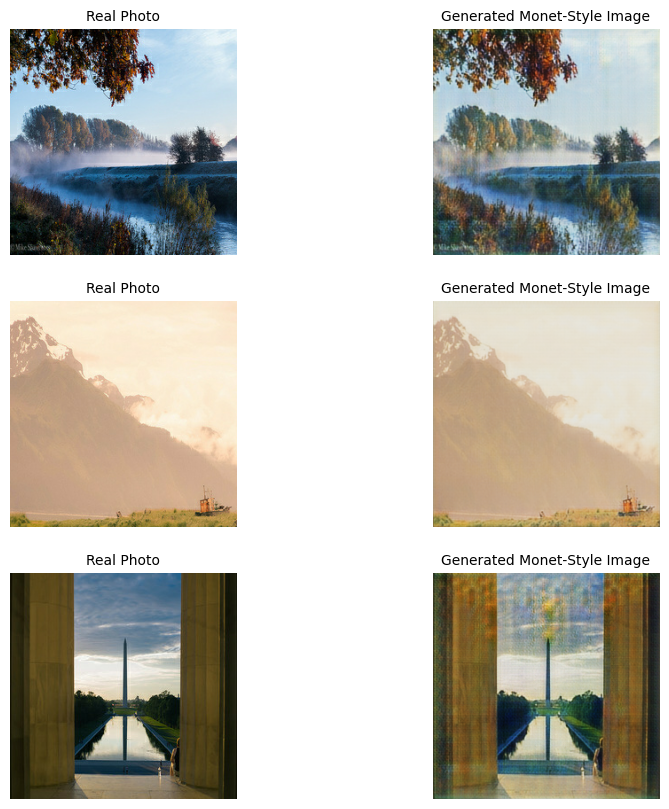

In [13]:
from itertools import islice
_, ax = plt.subplots(3, 2, figsize=(10, 10))

for i, img in enumerate(islice(photo_ds.take(88), 85, None)):
    pred = painting_generator(img, training=False)[0].numpy()
    pred = (pred * 127.5 + 127.5).astype(np.uint8)

    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(pred)
    ax[i, 0].set_title("Real Photo", fontsize = 10)
    ax[i, 1].set_title("Generated Monet-Style Image", fontsize = 10)
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

In [14]:
import os
from PIL import Image
from skimage.metrics import structural_similarity as ssim

output_dir = "/content/drive/MyDrive/GeneratedMonetPainting7038"
# output_dir = "/content/drive/MyDrive/GeneratedMonetPainting500"
# output_dir_501_1000 = "/content/drive/MyDrive/GeneratedMonetPainting501-1000"
os.makedirs(output_dir, exist_ok=True)
# os.makedirs(output_dir_501_1000, exist_ok=True)

def generate_and_save_images(photo_ds, painting_generator, output_dir):
    count = 0
    for img in photo_ds:
        # Generate Monet-style images
        pred = painting_generator(img, training=False)[0].numpy()

        # Convert dimension of pred to [0, 255]
        pred = (pred * 127.5 + 127.5).astype(np.uint8)

        # Save the image in output_dir
        img_path = os.path.join(output_dir, f"monet_style_{count}.png")
        Image.fromarray(pred).save(img_path)

        count += 1

        if count % 100 == 0:
            print(f"Generated {count} images")

        if count == 500:
            break


    # print(f"All {count} Monet-style images have been saved to {output_dir}.")

# generate_and_save_images(photo_ds, painting_generator, output_dir)

def generate_and_save_images_with_start_end(photo_ds, painting_generator, output_dir, start=501, end=1000):
    count = 0
    for i, img in enumerate(photo_ds):
        if i + 1 < start:
            continue

        if i + 1 > end:
            break

        pred = painting_generator(img, training=False)[0].numpy()

        pred = (pred * 127.5 + 127.5).astype(np.uint8)

        img_path = os.path.join(output_dir, f"monet_style_{count}.png")
        Image.fromarray(pred).save(img_path)

        count += 1

        if count % 100 == 0:
            print(f"Generated {count} images (from {start} to {end})")

    print(f"All {count} Monet-style images from {start} to {end} have been saved to {output_dir}.")

# generate_and_save_images_with_start_end(photo_ds, painting_generator, output_dir_501_1000, start=501, end=1000)


def generate_and_save_images_with_ssim(photo_ds, painting_generator, output_dir):
    count = 0
    total_ssim = 0
    ssim_scores = []

    for img in photo_ds:
        pred = painting_generator(img, training=False)[0].numpy()

        pred = (pred * 127.5 + 127.5).astype(np.uint8)

        real_img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

        img_path = os.path.join(output_dir, f"monet_style_{count}.png")
        Image.fromarray(pred).save(img_path)

        score = ssim(real_img, pred, multichannel=True, win_size=3)
        ssim_scores.append(score)
        total_ssim += score

        # print(f"SSIM for image {count}: {score}")

        count += 1
        if count % 100 == 0:
            print(f"Generated {count} images")

        # if count == 500:
            # break

    avg_ssim = total_ssim / count
    print(f"Average SSIM over {count} images: {avg_ssim}")

    return ssim_scores

generate_and_save_images_with_ssim(photo_ds, painting_generator, output_dir)


Generated 100 images
Generated 200 images
Generated 300 images
Generated 400 images
Generated 500 images
Generated 600 images
Generated 700 images
Generated 800 images
Generated 900 images
Generated 1000 images
Generated 1100 images
Generated 1200 images
Generated 1300 images
Generated 1400 images
Generated 1500 images
Generated 1600 images
Generated 1700 images
Generated 1800 images
Generated 1900 images
Generated 2000 images
Generated 2100 images
Generated 2200 images
Generated 2300 images
Generated 2400 images
Generated 2500 images
Generated 2600 images
Generated 2700 images
Generated 2800 images
Generated 2900 images
Generated 3000 images
Generated 3100 images
Generated 3200 images
Generated 3300 images
Generated 3400 images
Generated 3500 images
Generated 3600 images
Generated 3700 images
Generated 3800 images
Generated 3900 images
Generated 4000 images
Generated 4100 images
Generated 4200 images
Generated 4300 images
Generated 4400 images
Generated 4500 images
Generated 4600 imag

[0.5999953080773767,
 0.5154783509566927,
 0.7874180548945039,
 0.9048358362949146,
 0.8312560639366906,
 0.7514371960028768,
 0.7211578276221223,
 0.39928661242092384,
 0.6626832451561844,
 0.6463726912145836,
 0.6839136953841232,
 0.8092408568731363,
 0.8309585998635974,
 0.7372702716901964,
 0.8494526269534534,
 0.5163004705929514,
 0.8533104714986425,
 0.8507588053789664,
 0.8114616722136313,
 0.6772522981383938,
 0.7910606466955133,
 0.8588287036067745,
 0.8666734064654738,
 0.8095575052180696,
 0.8537959905243878,
 0.8224645828568283,
 0.7318343746178211,
 0.7311719990863994,
 0.7331430549808596,
 0.6043646325456618,
 0.7860926974289776,
 0.7407168229489841,
 0.6111607935523238,
 0.8556064602122387,
 0.43763950474524277,
 0.7452713615224981,
 0.7887089802325968,
 0.5451996437332339,
 0.8919577673506554,
 0.7247806914421914,
 0.8597465324126679,
 0.45935625440881345,
 0.7852577163125216,
 0.8254497909743979,
 0.707977920396847,
 0.8478009276064177,
 0.7447757704730603,
 0.55577224

In [1]:
from pytorch_fid import fid_score
import torch
output_dir = "/content/drive/MyDrive/GeneratedMonetPainting7038".
real_dir = '/content/drive/MyDrive/gan-getting-started/monet_jpg'
fid_value = fid_score.calculate_fid_given_paths(
    paths=[real_dir, output_dir],
    batch_size=50,
    device = "cuda",
    dims=2048
)

print(f"FID Score: {fid_value}")

100%|██████████| 141/141 [01:53<00:00,  1.24it/s]


FID Score: 114.88816250749448


In [ ]:
# just for fun
import os
import tensorflow as tf
from PIL import Image
import numpy as np

image_path = "/content/sample_photos/landscape_dd.jpeg"
resized_path = "/content/sample_photos/landscape_dd_resized.jpeg"
img = Image.open(image_path)

img_resized = img.resize((256, 256), Image.Resampling.LANCZOS)

img_resized = img_resized.convert("RGB")

img_resized.save(resized_path)
print(f"Resized image saved at {resized_path}")

def image_to_tfrecord(resized_path, output_tfrecord, name, target="default_target"):
    image = tf.io.read_file(resized_path)
    image = tf.image.decode_jpeg(image, channels=3)

    feature = {
        'image_name': tf.train.Feature(bytes_list=tf.train.BytesList(value=[name.encode()])),
        'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[tf.io.encode_jpeg(image).numpy()])),
        'target': tf.train.Feature(bytes_list=tf.train.BytesList(value=[target.encode()])),
    }

    example = tf.train.Example(features=tf.train.Features(feature=feature))
    serialized_example = example.SerializeToString()

    with tf.io.TFRecordWriter(output_tfrecord) as writer:
        writer.write(serialized_example)

resized_path = "/content/sample_photos/landscape_dd_resized.jpeg"
output_tfrecord = "/content/sample_photos_tfrec/landscape_dd.tfrecord"
image_name = "landscape_dd"
target_label = "default_target"
image_to_tfrecord(resized_path, output_tfrecord, image_name, target_label)


sample_ds_tfrec = tf.io.gfile.glob('/content/sample_photos_tfrec/*.tfrecord')
sample_ds = load_dataset(sample_ds_tfrec).batch(1)

_, ax = plt.subplots(1, 2, figsize=(10, 10))

for i, img in enumerate(sample_ds.take(1)):
    pred = painting_generator(img, training=False).numpy()[0]
    pred = (pred * 127.5 + 127.5).astype(np.uint8)

    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[0].imshow(img)
    ax[0].set_title("Real Photo", fontsize=10)
    ax[0].axis("off")

    ax[1].imshow(pred)
    ax[1].set_title("Generated Monet-Style Image", fontsize=10)
    ax[1].axis("off")

plt.show()